In [1]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fileinput
import re

from io import StringIO
from sklearn.preprocessing import MinMaxScaler

# Data Transformation and Features Engineering Area

In [2]:
train_file_path = "Data/PM_train.txt"
test_file_path = "Data/PM_test.txt"
colnames = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7",
           "s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

In [3]:
def move_col_last(df,col_name):
  return pd.concat([df.drop(col_name,axis=1),df[col_name]], axis=1)

def move_col_first(df,col_name):
  return pd.concat([df[col_name],df.drop(col_name,axis=1)], axis=1)

def transfer_data(file_path,col_names):
  # user defined variables to set the windows for classifcation
  w1 = 30
  w0 = 15
  # window size (window_size>=2),  most recent sensor values
  window_size = 5
  
  # read in the file
  with open(file_path, 'r') as f:
    filedata = f.read()
  
  # remove white space from the end of line
  filedata = re.sub('\s*$', '',filedata,flags = re.M)
  
  # filedata is a string that pretends to be a file input
  file_as_string = StringIO(filedata)

  dataset = pd.read_table(file_as_string,sep=" ",names=colnames)
  
  # get the maximum cycle number for each id
  d1 = dataset.groupby(["id"])["cycle"].max().to_frame()
  d1.columns = ['max']

  # add column with the name 'id' (just copy the index)
  d1['id'] = d1.index
  d2 = pd.merge(dataset, d1, on='id')
  
  # generate the column RUL based on the values of columns "max" and "cycle"
  d2['RUL'] = d2['max'] - d2['cycle']

  # exclude column "max" from the data frame
  d2 = d2.drop('max', 1)

  # genearte label1 and label2
  dataset = d2
  dataset['label1'] = np.where(d2['RUL'] <= w1, 1, 0)
  dataset['label2'] = np.where(d2['RUL'] <= w0, 2, (np.where(d2['RUL'] <= w1,1,0)))
  
  # exclude comuns id, cycle, setting1,setting2,setting3, and last 3 columns
  # only the 21 sensor columns are kept in the data frame
  n_pre_sensor_columns = 5 # id, cycle, setting1,setting2,setting3
  n_after_sensor_columns = 3 #RUL, label1, label2
  n_col = len(dataset.columns)

  data = dataset[dataset.columns[n_pre_sensor_columns:n_col - n_after_sensor_columns]]
  n_sensor=len(data.columns)

  ids = dataset.id.unique()
  n_id = len(ids) # 100

  a = ["a" + str(i) for i in range(1,n_sensor+1)] # average
  sd = ["sd" + str(i) for i in range(1,n_sensor+1)] # standard deviation

  df = None
  for i in range(1,n_id+1):
    # get the subset of the data that only contains the sensor columns for the id i
    subset_rolling_mean = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).mean()
    subset_rolling_mean.columns = a
    subset_rolling_std = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).std().fillna(0)
    subset_rolling_std.columns = sd
    subset = pd.concat([subset_rolling_mean,subset_rolling_std], axis=1)
    df_tmp = pd.concat([dataset[dataset.id == i],subset], axis=1)
    df_tmp = move_col_last(df_tmp,['RUL', 'label1','label2'])

    if df is None:
      df = df_tmp
    else:
      df = df.append(df_tmp,ignore_index=True)
      
  # Exclude column names: 'id','RUL','label1','label2'
  X = df.drop(['id','RUL','label1','label2'], 1)
  y = df['RUL']
  
  scaler = MinMaxScaler()
  X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

  
  # X = X.dropna(axis=1)

  return X,y.as_matrix()

In [4]:
X, y = transfer_data(train_file_path,colnames)
Xt, yt = transfer_data(test_file_path,colnames)

In [5]:
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_leaf_nodes=2000,max_depth=32)
regr_1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=32, max_features=None,
           max_leaf_nodes=2000, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [29]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
regr_1a = BaggingRegressor(DecisionTreeRegressor(max_depth=32,min_samples_split=128),n_estimators=8)
regr_1a.fit(X,y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=32, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=128, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=8, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [8]:
from sklearn.cross_validation import cross_val_score
scores = -cross_val_score(regr_1, Xt,yt, scoring='neg_mean_absolute_error', cv=10)
scores.mean()

/Users/Amer/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


46.422886556735648

In [35]:
from sklearn import linear_model
regr_2 = linear_model.Lasso(alpha =.1)
regr_2.fit(X,y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
from sklearn import neural_network
regr_3 = neural_network.MLPRegressor(alpha=.1,max_iter=400,hidden_layer_sizes=(50,),solver='lbfgs',random_state=1)
regr_3.fit(X,y)

MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [11]:
print(regr_3.score(Xt,yt))
np.mean((regr_3.predict(Xt)-yt)**2)

-0.102191753156


3102.5703874464471

In [ ]:
from sklearn import linear_model
regr_7 = linear_model.LogisticRegression()
regr_7.fit(X,y)

In [ ]:
print(regr_7.score(Xt,yt))
np.mean((regr_7.predict(Xt)-yt)**2)

In [ ]:
from sklearn import linear_model
regr_4 = linear_model.LinearRegression()
regr_4.fit(X, y)
#print(regr_4.coef_)

# The mean square error
np.mean((regr_4.predict(Xt)-yt)**2)

In [7]:
from sklearn import linear_model
regr_5 = linear_model.SGDRegressor()
regr_5.fit(X, y)
np.mean((regr_5.predict(Xt)-yt)**2)

/Users/Amer/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


3738.4542332567917

In [ ]:
from sklearn import linear_model
regr_6 = linear_model.Ridge(alpha = .5,normalize=True)
regr_6.fit(X,y)
np.mean((regr_6.predict(Xt)-yt)**2)

In [ ]:
# #############################################################################
# Compute train and test errors
from sklearn import linear_model

coef = len(X.columns)

alphas = np.logspace(-5, 1, 60)
enet = linear_model.ElasticNet(l1_ratio=0.7)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X, y)
    train_errors.append(enet.score(X, y))
    test_errors.append(enet.score(Xt, yt))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

In [ ]:
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

# Show estimated coef_ vs true coef
plt.subplot(2, 1, 2)
plt.plot(coef, label='True coef')
plt.scatter(coef_, label='Estimated coef')
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
y_prdc_1 = regr_1.predict(Xt)
plt.show()

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
regr_9 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=32,max_leaf_nodes=20,min_samples_leaf=10),n_estimators=100,learning_rate=0.2, random_state=0)
regr_9.fit(X,y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=32, max_features=None,
           max_leaf_nodes=20, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=0.2, loss='linear', n_estimators=100,
         random_state=0)

# Charts

In [46]:
# Select subset
len(Xt) # 13096
start = 2000 
end = 3100 #len(Xt)

points = np.arange(start, end, 1.0)

In [40]:
y_prdc_1 = regr_1.predict(Xt)
y_prdc_1a = regr_1a.predict(Xt)
y_prdc_2 = regr_2.predict(Xt)
y_prdc_3 = regr_3.predict(Xt)
#y_prdc_4 = regr_4.predict(Xt)
#y_prdc_5 = regr_5.predict(Xt)
#y_prdc_6 = regr_6.predict(Xt)
#y_prdc_7 = regr_7.predict(Xt)
#y_prdc_8 = regr_8.predict(Xt)
y_prdc_9 = regr_9.predict(Xt)

print(regr_1.score(Xt,yt)) # Decision Tree Regressor
print(regr_1a.score(Xt,yt))# Bagging
print(regr_2.score(Xt,yt)) # Lasso
print(regr_3.score(Xt,yt)) # Neural Netwrok
#print(regr_4.score(Xt,yt)) # LinearRegression
#print(regr_5.score(Xt,yt)) # SGDRegressor
#print(regr_6.score(Xt,yt)) # Ridge
#print(regr_7.score(Xt,yt)) # Logistic Regression
#print(regr_8.score(Xt,yt)) # Polynomial Regression
print(regr_9.score(Xt,yt))  # Boosted Decision Tree Regression

-1.31700204458
-0.690089815406
-0.43172053247
-0.102191753156
-0.873417826487


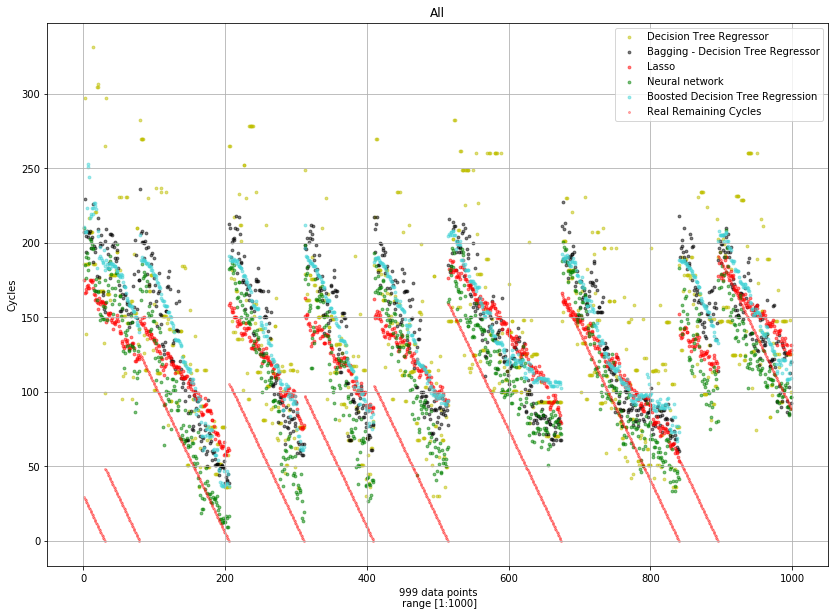

In [72]:

# Plot the results
plt.figure(figsize=(14,10))

plt.scatter(np.arange(start, end, 1),y_prdc_1[start:end], c="y", s=8,alpha=0.5, label="Decision Tree Regressor")
plt.scatter(np.arange(start, end, 1),y_prdc_1a[start:end], c="k", s=8,alpha=0.5, label="Bagging - Decision Tree Regressor")
plt.scatter(np.arange(start, end, 1),y_prdc_2[start:end], c="r", s=8,alpha=0.5, label="Lasso")
plt.scatter(np.arange(start, end, 1),y_prdc_3[start:end], c="g", s=8,alpha=0.5, label="Neural network")
#plt.scatter(np.arange(start, end, 1),y_prdc_4[start:end], c="b", s=4,alpha=0.5, label="LinearRegression")
#plt.scatter(np.arange(start, end, 1),y_prdc_5[start:end], c="c", s=4,alpha=0.5, label="SGDRegressor")
#plt.scatter(np.arange(start, end, 1),y_prdc_6[start:end], c="y", s=4,alpha=0.5, label="Ridge")
#plt.scatter(np.arange(start, end, 1),y_prdc_7[start:end], c="c", s=4,alpha=0.5, label="Logistic Regression")
#plt.scatter(np.arange(start, end, 1),y_prdc_8[start:end], c="#080972", s=4,alpha=0.5, label="Polynomial Regression")
plt.scatter(np.arange(start, end, 1),y_prdc_9[start:end], c="#42d3d6", s=8,alpha=0.5, label="Boosted Decision Tree Regression")

# Test Samples
plt.scatter(np.arange(start, end,1),yt[start:end], c="r", s=4, alpha=0.3, label="Real Remaining Cycles")

plt.grid()
plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
plt.ylabel("Cycles")
plt.title("All")
plt.legend()
plt.show()

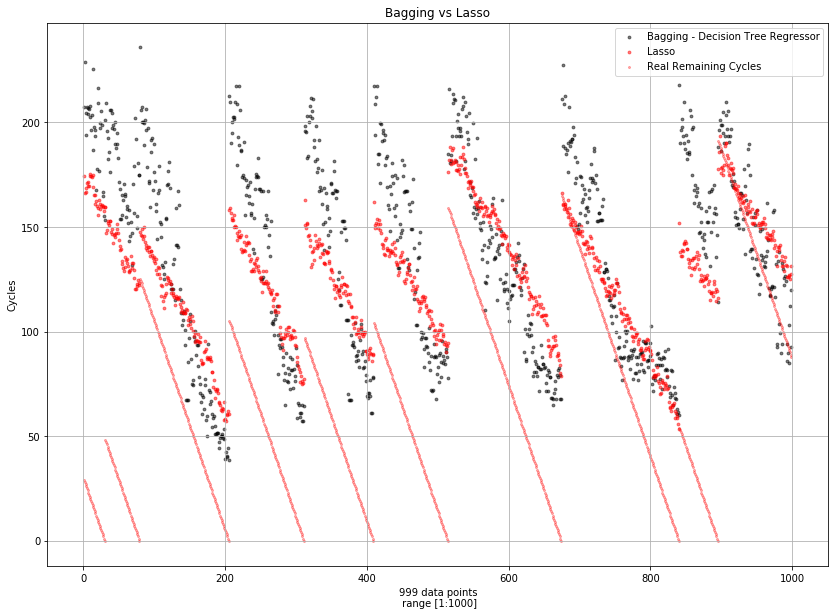

In [73]:
# Plot the results
plt.figure(figsize=(14,10))

plt.scatter(np.arange(start, end, 1),y_prdc_1a[start:end], c="k", s=8,alpha=0.5, label="Bagging - Decision Tree Regressor")
plt.scatter(np.arange(start, end, 1),y_prdc_2[start:end], c="r", s=8,alpha=0.5, label="Lasso")


# Test Samples
plt.scatter(np.arange(start, end,1),yt[start:end], c="r", s=4, alpha=0.3, label="Real Remaining Cycles")

plt.grid()
plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
plt.ylabel("Cycles")
plt.title("Bagging vs Lasso")
plt.legend()
plt.show()

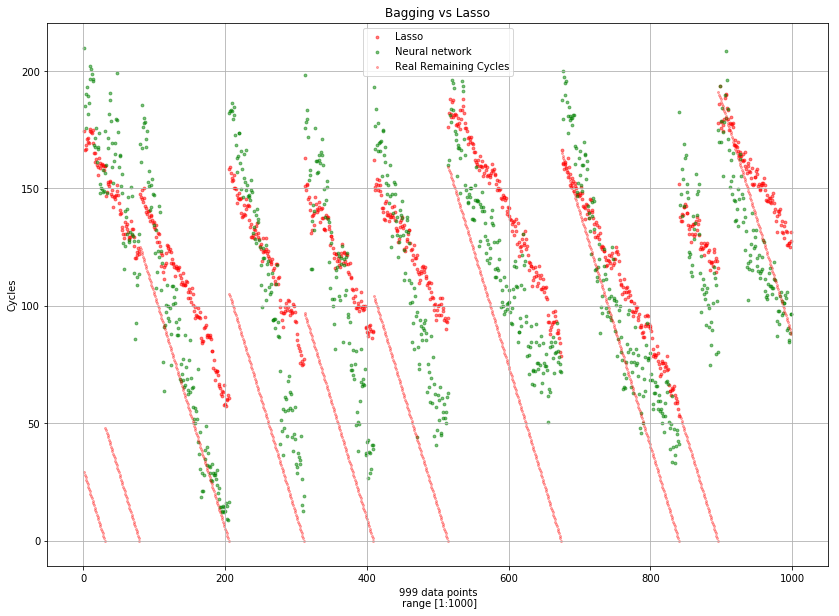

In [74]:
# Plot the results
plt.figure(figsize=(14,10))

plt.scatter(np.arange(start, end, 1),y_prdc_2[start:end], c="r", s=8,alpha=0.5, label="Lasso")
plt.scatter(np.arange(start, end, 1),y_prdc_3[start:end], c="g", s=8,alpha=0.5, label="Neural network")


# Test Samples
plt.scatter(np.arange(start, end,1),yt[start:end], c="r", s=4, alpha=0.3, label="Real Remaining Cycles")

plt.grid()
plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
plt.ylabel("Cycles")
plt.title("Bagging vs Lasso")
plt.legend()
plt.show()

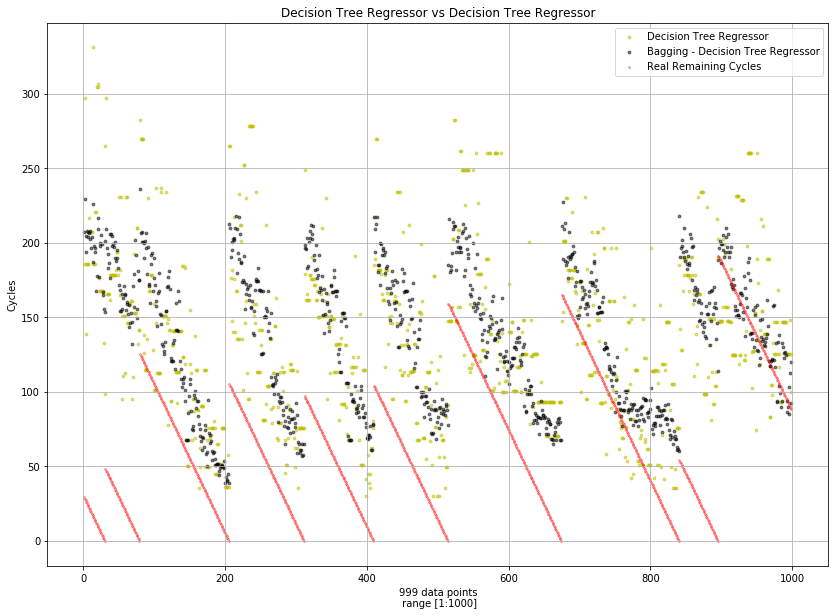

In [75]:
# Plot the results
plt.figure(figsize=(14,10))

plt.scatter(np.arange(start, end, 1),y_prdc_1[start:end], c="y", s=8,alpha=0.5, label="Decision Tree Regressor")
plt.scatter(np.arange(start, end, 1),y_prdc_1a[start:end], c="k", s=8,alpha=0.5, label="Bagging - Decision Tree Regressor")


# Test Samples
plt.scatter(np.arange(start, end,1),yt[start:end], c="r", s=4, alpha=0.3, label="Real Remaining Cycles")

plt.grid()
plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
plt.ylabel("Cycles")
plt.title("Decision Tree Regressor vs Decision Tree Regressor")
plt.legend()
plt.show()

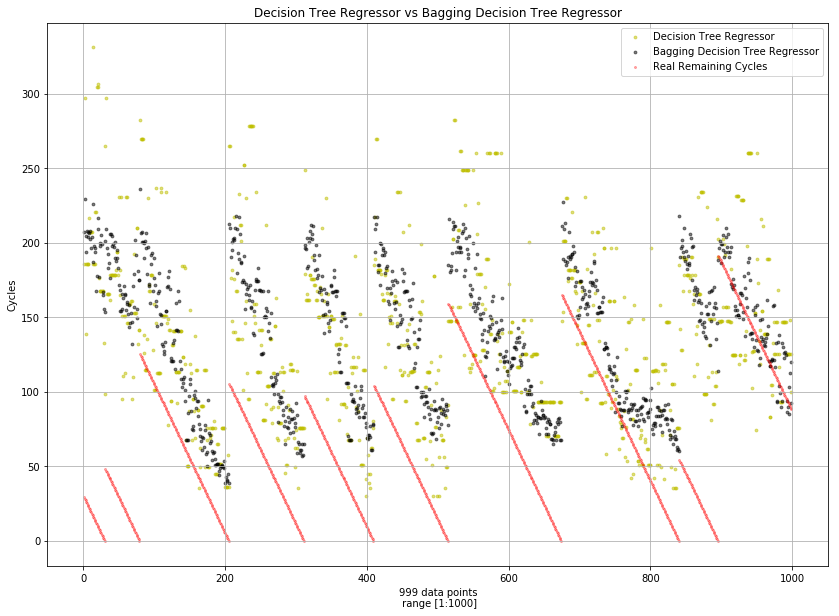

In [71]:
# Select subset
len(Xt) # 13096
start = 1 
end = 1000 #len(Xt)


#print(regr_1.score(Xt,yt)) # Decision Tree Regressor
#print(regr_1a.score(Xt,yt))# Bagging
#print(regr_2.score(Xt,yt)) # Lasso
#print(regr_3.score(Xt,yt)) # Neural Netwrok
#print(regr_4.score(Xt,yt)) # LinearRegression
#print(regr_5.score(Xt,yt)) # SGDRegressor
#print(regr_6.score(Xt,yt)) # Ridge
#print(regr_7.score(Xt,yt)) # Logistic Regression
#print(regr_8.score(Xt,yt)) # Polynomial Regression
#print(regr_9.score(Xt,yt))  # Boosted Decision Tree Regression

y_prdc_1 = regr_1.predict(Xt)
points = np.arange(start, end, 1.0)

# Plot the results
plt.figure(figsize=(14,10))

plt.scatter(np.arange(start, end, 1),y_prdc_1[start:end], c="y", s=8,alpha=0.5, label="Decision Tree Regressor")
plt.scatter(np.arange(start, end, 1),y_prdc_1a[start:end], c="k", s=8,alpha=0.5, label="Bagging Decision Tree Regressor")

# Test Samples
plt.scatter(np.arange(start, end,1),yt[start:end], c="r", s=4, alpha=0.3, label="Real Remaining Cycles")

plt.grid()

plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
plt.ylabel("Cycles")
plt.title("Decision Tree Regressor vs Bagging Decision Tree Regressor")
plt.legend()
plt.show()

# TODO 
## different between generated features and the original  ones 
## different subset of features

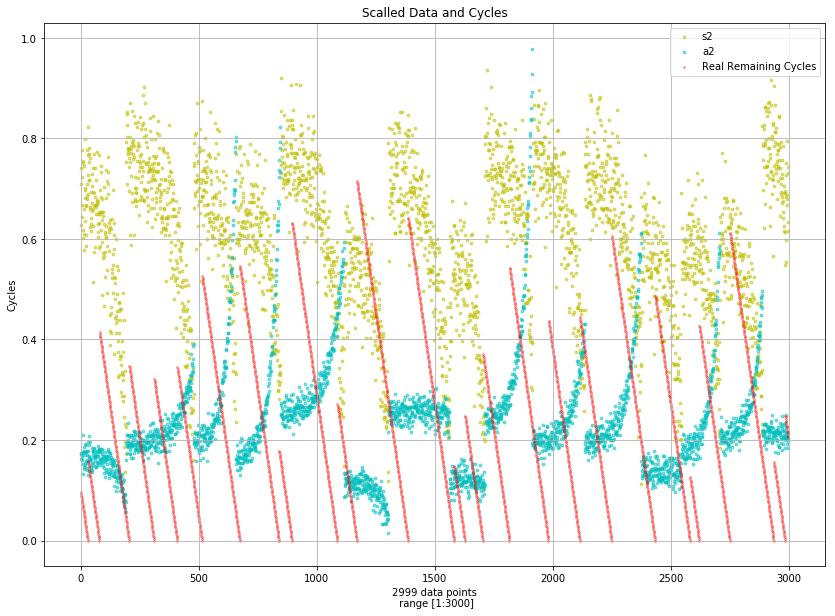

In [70]:
# Select subset
len(Xt) # 13096
start = 1
end = 3000 #len(Xt)

# Plot the results
plt.figure(figsize=(14,10))

plt.scatter(np.arange(start, end, 1),X['s7'][start:end], c="y", s=8,alpha=0.5, label="s2")
plt.scatter(np.arange(start, end, 1),X['s14'][start:end], c="c", s=8,alpha=0.5, label="a2")

# Scalling Cycles
scaler = MinMaxScaler()
yt_scaled = pd.DataFrame(scaler.fit_transform(pd.DataFrame(yt)))
y_prdc_3_scaled = pd.DataFrame(scaler.fit_transform(pd.DataFrame(y_prdc_3)))

# Plot scaled cycles as red dots
plt.scatter(np.arange(start, end,1),yt_scaled[start:end] , c="r", s=4, alpha=0.3, label="Real Remaining Cycles")

# Plot predictd cycles by Neural network as green dots (scaled)
#plt.scatter(np.arange(start, end, 1),y_prdc_3_scaled[start:end], c="g", s=8,alpha=0.5, label="Neural network")

plt.grid()
plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
plt.ylabel("Cycles")
plt.title("Scalled Data and Cycles")
plt.legend()
plt.show()